<a href="https://colab.research.google.com/github/deepakgowtham/EVA4/blob/master/Week5/Session_5_1_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


In [3]:
use_cuda = torch.cuda.is_available()

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
SEED=1
# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

torch.manual_seed(1)
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


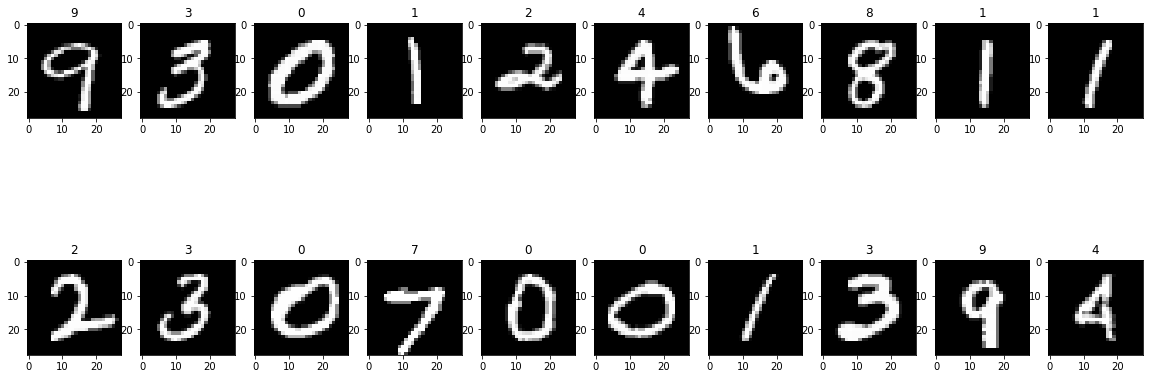

In [4]:
images, label = next(iter(train_loader))
fig = plt.figure(figsize=(20, 8))
for i in range(20):
  ax=fig.add_subplot(2, 10, i+1)
  img= np.squeeze(images[i].numpy())
  ax.imshow(img, cmap='gray')
  ax.set_title(str(label[i].item()))



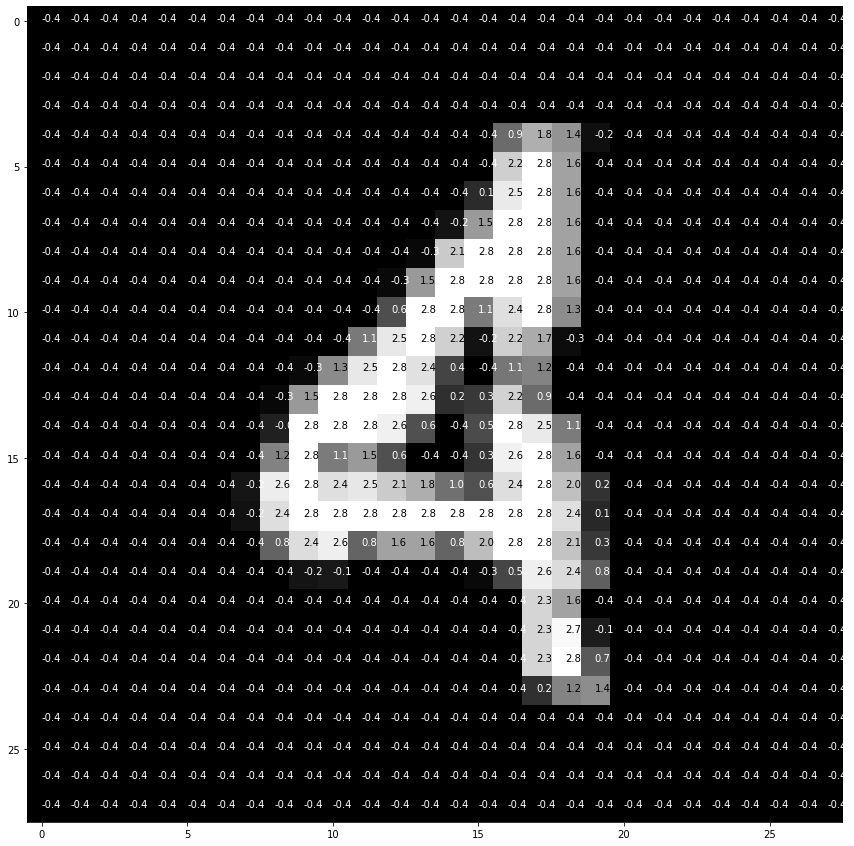

In [5]:
width, height = img.shape
fig= plt.figure(figsize=(15,15))
ax= fig.add_subplot(1,1,1)
ax.imshow(img, cmap='gray')
thresh =img.max()/2.5
for x in range(width):
  for y in range(height):
    val= round(img[x][y],1) if img[x][y] !=0 else 0
    ax.annotate(str(val), xy= (y,x),
                color='white' if val< thresh else 'black')

In [6]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [0]:
class Net2(nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    self.conv_block1= nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), bias=False),
        nn.BatchNorm2d(8),
        nn.ReLU(),#output size 26
        nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3),  bias=False),
        nn.BatchNorm2d(8),
        nn.ReLU(), #output size 24
    )
    self.trans_block1= nn.Sequential(
        nn.MaxPool2d(2,2),#output size 14
        
    )
    self.conv_block2= nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3), bias=False),
        nn.BatchNorm2d(8),
        nn.ReLU(),  #output size 10

        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), bias=False),
        nn.BatchNorm2d(16),
        nn.ReLU(), #output size 8

       

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU() #output size 6
    )

    self.trans_block2= nn.Sequential(
        nn.AvgPool2d(kernel_size=6),
        nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1,1))
    )

  def forward(self, x):
    x= self.conv_block1(x)
    x= self.trans_block1(x)
    x= self.conv_block2(x)
    x= self.trans_block2(x)
    x = x.view(-1, 10)
    return F.log_softmax(x)


In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net2().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             576
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
         MaxPool2d-7            [-1, 8, 12, 12]               0
            Conv2d-8            [-1, 8, 10, 10]             576
       BatchNorm2d-9            [-1, 8, 10, 10]              16
             ReLU-10            [-1, 8, 10, 10]               0
           Conv2d-11             [-1, 16, 8, 8]           1,152
      BatchNorm2d-12             [-1, 16, 8, 8]              32
             ReLU-13             [-1, 16, 8, 8]               0
           Conv2d-14             [-1, 3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.3)
#scheduler = StepLR(optimizer, step_size=1, gamma=0.83)

for epoch in range(1, 16):
    print(f'Epoch: {epoch}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    #scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.015135079622268677 Batch_id=937 Accuracy=93.81: 100%|██████████| 938/938 [00:17<00:00, 54.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0650, Accuracy: 9808/10000 (98.08%)

Epoch: 2


Loss=0.1579531580209732 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:16<00:00, 55.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0745, Accuracy: 9765/10000 (97.65%)

Epoch: 3


Loss=0.011025160551071167 Batch_id=937 Accuracy=98.49: 100%|██████████| 938/938 [00:16<00:00, 55.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9895/10000 (98.95%)

Epoch: 4


Loss=0.012002065777778625 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:16<00:00, 55.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9900/10000 (99.00%)

Epoch: 5


Loss=0.02165590226650238 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:16<00:00, 55.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9915/10000 (99.15%)

Epoch: 6


Loss=0.038600027561187744 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:16<00:00, 55.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9911/10000 (99.11%)

Epoch: 7


Loss=0.0012620985507965088 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:16<00:00, 56.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9875/10000 (98.75%)

Epoch: 8


Loss=0.008495211601257324 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:17<00:00, 54.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9918/10000 (99.18%)

Epoch: 9


Loss=0.16989462077617645 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:17<00:00, 54.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9904/10000 (99.04%)

Epoch: 10


Loss=0.0014285296201705933 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:16<00:00, 55.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9901/10000 (99.01%)

Epoch: 11


Loss=0.008971720933914185 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:17<00:00, 53.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9925/10000 (99.25%)

Epoch: 12


Loss=0.0012665987014770508 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:17<00:00, 54.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9931/10000 (99.31%)

Epoch: 13


Loss=0.02063608169555664 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:16<00:00, 55.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

Epoch: 14


Loss=0.0005566179752349854 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [00:17<00:00, 53.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9905/10000 (99.05%)

Epoch: 15


Loss=0.0019320249557495117 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [00:16<00:00, 56.58it/s]



Test set: Average loss: 0.0212, Accuracy: 9938/10000 (99.38%)



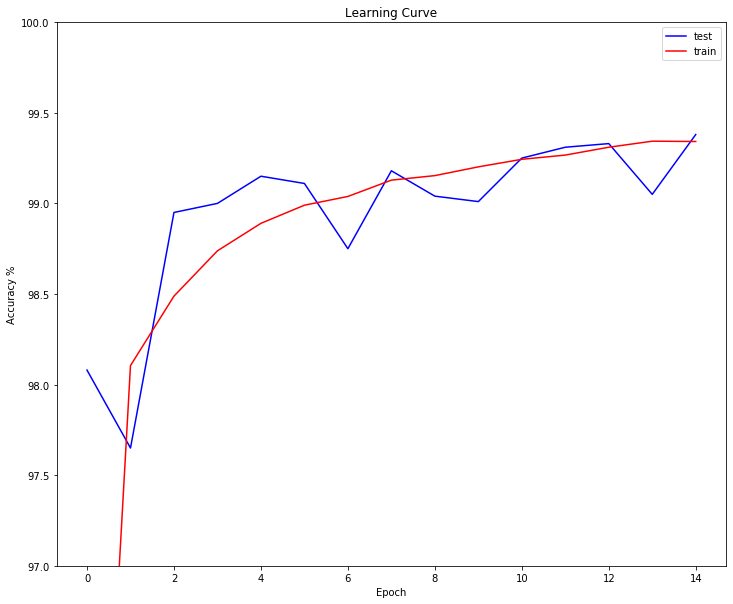

In [16]:
fig= plt.figure(figsize=(12,10))
ax= fig.add_subplot(1,1,1)
#ax.plot( train_acc, color='red')
ax.plot(test_acc, color='blue',label='test')
#ax2=fig.add_subplot(1,2,2)
ax.plot( train_acc, color='red',label='train')
ax.legend()
ax.set_ylim(97,100)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy %')
ax.set_title('Learning Curve')
plt.show()

# Inference Code 1:
## Target:
- Visualise the data
- Setup data loader and transforms
- Get the architecture right under 10k Params
- Dry run with approximately good learning rate.

## Results:
- Total params: 7,458
- Train accuracy in last epoch: 99.34
- Test accuracy in last epoch : 99.38%
- Best test accuracy seen: 99.38%

## Analysis:
- Model is performing well, overfitting observed only in few epochs
- Can improve the model by adding data agumentation